# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [40]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import joblib

mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

### Plotting Functions 

In [41]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'o',color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc':
        Aux = np.linspace(50,300)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(140, 180, '$+ 10 \%$', fontsize=12)
        plt.text(150, 120, '$- 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - NN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(23, 17, '$- 10 \%$', fontsize=12)
        plt.text(19, 28, '$+ 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - NN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,Mag}$ [W] - Target')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [42]:
Inputs = pd.read_excel('Data/Data_AMR.xlsx',index_col = 0, dtype=np.float32) # Input Data
X = Inputs[['W','H','f','mf','B','L','Th','Tc']]
y = Inputs[['Qc','Wm']]

### Train-Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)  

### Scaling the Features

In [44]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [57]:
joblib.dump(sc, 'Models/AMR_Scaler.pkl') 

['Models/AMR_Scaler.pkl']

### Building the Model

In [46]:
def Build(hp):
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    model.add(BatchNormalization())
    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    for i in range(hp.Int('layers', 0, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 1, 301, step=3),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu'])))
        #model.add(Dropout(0.05))
        #Applying a Batch Normalization Layer after Dense Layer
        model.add(BatchNormalization())

        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, activation='selu'))
    
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(),
                  loss="mean_squared_error",
                  #metrics=['accuracy']
                  metrics = ['mean_squared_error']
                 )
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [47]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1, 501, step=5)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [58]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    max_epochs = max_epochs,
                    directory='KT_Dir',
                    project_name='KT_Hyperband_' + Obj,
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 #callbacks=[EarlyStopping('val_loss', patience=20)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(X_train.shape)
    best_model.fit(X_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    best_model.summary()
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test)))) 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

INFO:tensorflow:Reloading Oracle from existing project KT_Dir\KT_Hyperband_Qc\oracle.json
INFO:tensorflow:Reloading Tuner from KT_Dir\KT_Hyperband_Qc\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
11/11 [==============================] - 0s 2ms/step - loss: 83.5477 - mean_squared_error: 83.5477
Epoch 2/1000
11/11 [==============================] - 0s 2ms/step - loss: 48.6360 - mean_squared_error: 48.6360
Epoch 3/1000
11/11 [==============================] - 0s 2ms/step - loss: 92.7030 - mean_squared_error: 92.7030
Epoch 4/1000
11/11 [==============================] - 0s 2ms/step - loss: 63.1706 - mean_squared_error: 63.1706
Epoch 5/1000
11/11 [==============================] - 0s 2ms/step - loss: 77.7005 - mean_squared_error: 77.7005
Epoch 6/1000
11/11 [==============================] - 0s 2ms/step - loss: 84.4131 - mean_squared_error: 84.4131
Epoch 7/1000
11/11 [==============================] - 0s 2ms/step - loss: 80.0700 - mean_squared_error: 80.0700
Epoch 8/1000
11/

11/11 [==============================] - 0s 2ms/step - loss: 89.5645 - mean_squared_error: 89.5645
Epoch 72/1000
11/11 [==============================] - 0s 2ms/step - loss: 80.2419 - mean_squared_error: 80.2419
Epoch 73/1000
11/11 [==============================] - 0s 2ms/step - loss: 82.1434 - mean_squared_error: 82.1434
Epoch 74/1000
11/11 [==============================] - 0s 2ms/step - loss: 80.4525 - mean_squared_error: 80.4525
Epoch 75/1000
11/11 [==============================] - 0s 2ms/step - loss: 68.3288 - mean_squared_error: 68.3288
Epoch 76/1000
11/11 [==============================] - 0s 2ms/step - loss: 83.5441 - mean_squared_error: 83.5441
Epoch 77/1000
11/11 [==============================] - 0s 2ms/step - loss: 112.6773 - mean_squared_error: 112.6773
Epoch 78/1000
11/11 [==============================] - 0s 2ms/step - loss: 71.2188 - mean_squared_error: 71.2188
Epoch 79/1000
11/11 [==============================] - 0s 2ms/step - loss: 128.0260 - mean_squared_error: 12

11/11 [==============================] - 0s 2ms/step - loss: 57.9207 - mean_squared_error: 57.9207
Epoch 144/1000
11/11 [==============================] - 0s 2ms/step - loss: 94.8372 - mean_squared_error: 94.8372
Epoch 145/1000
11/11 [==============================] - 0s 2ms/step - loss: 69.9807 - mean_squared_error: 69.9807
Epoch 146/1000
11/11 [==============================] - 0s 2ms/step - loss: 58.2747 - mean_squared_error: 58.2747
Epoch 147/1000
11/11 [==============================] - 0s 2ms/step - loss: 43.1948 - mean_squared_error: 43.1948
Epoch 148/1000
11/11 [==============================] - 0s 2ms/step - loss: 69.3558 - mean_squared_error: 69.3558
Epoch 149/1000
11/11 [==============================] - 0s 2ms/step - loss: 77.1581 - mean_squared_error: 77.1581
Epoch 150/1000
11/11 [==============================] - 0s 2ms/step - loss: 96.9430 - mean_squared_error: 96.9430
Epoch 151/1000
11/11 [==============================] - 0s 3ms/step - loss: 84.1063 - mean_squared_erro

11/11 [==============================] - 0s 2ms/step - loss: 45.4921 - mean_squared_error: 45.4921
Epoch 215/1000
11/11 [==============================] - 0s 2ms/step - loss: 108.0292 - mean_squared_error: 108.0292
Epoch 216/1000
11/11 [==============================] - 0s 2ms/step - loss: 118.4708 - mean_squared_error: 118.4708
Epoch 217/1000
11/11 [==============================] - 0s 2ms/step - loss: 121.0046 - mean_squared_error: 121.0046
Epoch 218/1000
11/11 [==============================] - 0s 2ms/step - loss: 60.7877 - mean_squared_error: 60.7877
Epoch 219/1000
11/11 [==============================] - 0s 2ms/step - loss: 114.2071 - mean_squared_error: 114.2071
Epoch 220/1000
11/11 [==============================] - 0s 2ms/step - loss: 53.6350 - mean_squared_error: 53.6350
Epoch 221/1000
11/11 [==============================] - 0s 2ms/step - loss: 94.6200 - mean_squared_error: 94.6200
Epoch 222/1000
11/11 [==============================] - 0s 2ms/step - loss: 61.0948 - mean_squa

11/11 [==============================] - 0s 2ms/step - loss: 70.5539 - mean_squared_error: 70.5539
Epoch 286/1000
11/11 [==============================] - 0s 2ms/step - loss: 87.0914 - mean_squared_error: 87.0914
Epoch 287/1000
11/11 [==============================] - 0s 2ms/step - loss: 130.2712 - mean_squared_error: 130.2712
Epoch 288/1000
11/11 [==============================] - 0s 2ms/step - loss: 79.3771 - mean_squared_error: 79.3771
Epoch 289/1000
11/11 [==============================] - 0s 2ms/step - loss: 75.8975 - mean_squared_error: 75.8975
Epoch 290/1000
11/11 [==============================] - 0s 2ms/step - loss: 72.3007 - mean_squared_error: 72.3007
Epoch 291/1000
11/11 [==============================] - 0s 2ms/step - loss: 56.3829 - mean_squared_error: 56.3829
Epoch 292/1000
11/11 [==============================] - 0s 2ms/step - loss: 56.5809 - mean_squared_error: 56.5809
Epoch 293/1000
11/11 [==============================] - 0s 2ms/step - loss: 67.5369 - mean_squared_er

11/11 [==============================] - 0s 2ms/step - loss: 67.7532 - mean_squared_error: 67.7532
Epoch 357/1000
11/11 [==============================] - 0s 2ms/step - loss: 54.1574 - mean_squared_error: 54.1574
Epoch 358/1000
11/11 [==============================] - 0s 2ms/step - loss: 108.4819 - mean_squared_error: 108.4819
Epoch 359/1000
11/11 [==============================] - 0s 2ms/step - loss: 52.5002 - mean_squared_error: 52.5002
Epoch 360/1000
11/11 [==============================] - 0s 2ms/step - loss: 81.8300 - mean_squared_error: 81.8300
Epoch 361/1000
11/11 [==============================] - 0s 2ms/step - loss: 81.4180 - mean_squared_error: 81.4180
Epoch 362/1000
11/11 [==============================] - 0s 2ms/step - loss: 56.5033 - mean_squared_error: 56.5033
Epoch 363/1000
11/11 [==============================] - 0s 2ms/step - loss: 124.6925 - mean_squared_error: 124.6925
Epoch 364/1000
11/11 [==============================] - 0s 2ms/step - loss: 76.1122 - mean_squared_

11/11 [==============================] - 0s 2ms/step - loss: 79.5739 - mean_squared_error: 79.5739
Epoch 428/1000
11/11 [==============================] - 0s 2ms/step - loss: 87.7047 - mean_squared_error: 87.7047
Epoch 429/1000
11/11 [==============================] - 0s 2ms/step - loss: 55.4691 - mean_squared_error: 55.4691
Epoch 430/1000
11/11 [==============================] - 0s 2ms/step - loss: 124.3094 - mean_squared_error: 124.3094
Epoch 431/1000
11/11 [==============================] - 0s 2ms/step - loss: 84.7851 - mean_squared_error: 84.7851
Epoch 432/1000
11/11 [==============================] - 0s 2ms/step - loss: 90.1280 - mean_squared_error: 90.1280
Epoch 433/1000
11/11 [==============================] - 0s 2ms/step - loss: 106.6386 - mean_squared_error: 106.6386
Epoch 434/1000
11/11 [==============================] - 0s 2ms/step - loss: 94.9581 - mean_squared_error: 94.9581
Epoch 435/1000
11/11 [==============================] - 0s 2ms/step - loss: 70.7654 - mean_squared_

11/11 [==============================] - 0s 2ms/step - loss: 74.9298 - mean_squared_error: 74.9298
Epoch 499/1000
11/11 [==============================] - 0s 2ms/step - loss: 75.8662 - mean_squared_error: 75.8662
Epoch 500/1000
11/11 [==============================] - 0s 2ms/step - loss: 58.6744 - mean_squared_error: 58.6744
Epoch 501/1000
11/11 [==============================] - 0s 2ms/step - loss: 62.1586 - mean_squared_error: 62.1586
Epoch 502/1000
11/11 [==============================] - 0s 2ms/step - loss: 62.7958 - mean_squared_error: 62.7958
Epoch 503/1000
11/11 [==============================] - 0s 2ms/step - loss: 83.1872 - mean_squared_error: 83.1872
Epoch 504/1000
11/11 [==============================] - 0s 2ms/step - loss: 40.1266 - mean_squared_error: 40.1266
Epoch 505/1000
11/11 [==============================] - 0s 2ms/step - loss: 77.9038 - mean_squared_error: 77.9038
Epoch 506/1000
11/11 [==============================] - 0s 2ms/step - loss: 80.4049 - mean_squared_erro

11/11 [==============================] - 0s 2ms/step - loss: 86.9042 - mean_squared_error: 86.9042
Epoch 570/1000
11/11 [==============================] - 0s 2ms/step - loss: 63.4927 - mean_squared_error: 63.4927
Epoch 571/1000
11/11 [==============================] - 0s 2ms/step - loss: 40.8984 - mean_squared_error: 40.8984
Epoch 572/1000
11/11 [==============================] - 0s 2ms/step - loss: 69.8626 - mean_squared_error: 69.8626
Epoch 573/1000
11/11 [==============================] - 0s 2ms/step - loss: 59.7801 - mean_squared_error: 59.7801
Epoch 574/1000
11/11 [==============================] - 0s 2ms/step - loss: 78.7832 - mean_squared_error: 78.7832
Epoch 575/1000
11/11 [==============================] - 0s 2ms/step - loss: 55.8707 - mean_squared_error: 55.8707
Epoch 576/1000
11/11 [==============================] - 0s 2ms/step - loss: 93.9883 - mean_squared_error: 93.9883
Epoch 577/1000
11/11 [==============================] - 0s 3ms/step - loss: 66.2385 - mean_squared_erro

11/11 [==============================] - 0s 2ms/step - loss: 85.5920 - mean_squared_error: 85.5920
Epoch 641/1000
11/11 [==============================] - 0s 2ms/step - loss: 71.9447 - mean_squared_error: 71.9447
Epoch 642/1000
11/11 [==============================] - 0s 2ms/step - loss: 76.9623 - mean_squared_error: 76.9623
Epoch 643/1000
11/11 [==============================] - 0s 2ms/step - loss: 70.5468 - mean_squared_error: 70.5468
Epoch 644/1000
11/11 [==============================] - 0s 2ms/step - loss: 78.5236 - mean_squared_error: 78.5236
Epoch 645/1000
11/11 [==============================] - 0s 2ms/step - loss: 45.7021 - mean_squared_error: 45.7021
Epoch 646/1000
11/11 [==============================] - 0s 3ms/step - loss: 76.2147 - mean_squared_error: 76.2147
Epoch 647/1000
11/11 [==============================] - 0s 3ms/step - loss: 70.5687 - mean_squared_error: 70.5687
Epoch 648/1000
11/11 [==============================] - 0s 2ms/step - loss: 91.9791 - mean_squared_erro

11/11 [==============================] - 0s 2ms/step - loss: 60.5757 - mean_squared_error: 60.5757
Epoch 712/1000
11/11 [==============================] - 0s 2ms/step - loss: 37.4799 - mean_squared_error: 37.4799
Epoch 713/1000
11/11 [==============================] - 0s 2ms/step - loss: 48.2124 - mean_squared_error: 48.2124
Epoch 714/1000
11/11 [==============================] - 0s 3ms/step - loss: 115.0527 - mean_squared_error: 115.0527
Epoch 715/1000
11/11 [==============================] - 0s 3ms/step - loss: 75.7084 - mean_squared_error: 75.7084
Epoch 716/1000
11/11 [==============================] - 0s 2ms/step - loss: 59.8602 - mean_squared_error: 59.8602
Epoch 717/1000
11/11 [==============================] - 0s 2ms/step - loss: 37.2529 - mean_squared_error: 37.2529
Epoch 718/1000
11/11 [==============================] - 0s 2ms/step - loss: 58.6793 - mean_squared_error: 58.6793
Epoch 719/1000
11/11 [==============================] - 0s 2ms/step - loss: 61.7297 - mean_squared_er

11/11 [==============================] - 0s 2ms/step - loss: 95.1427 - mean_squared_error: 95.1427
Epoch 783/1000
11/11 [==============================] - 0s 2ms/step - loss: 83.8104 - mean_squared_error: 83.8104
Epoch 784/1000
11/11 [==============================] - 0s 2ms/step - loss: 109.8033 - mean_squared_error: 109.8033
Epoch 785/1000
11/11 [==============================] - 0s 2ms/step - loss: 136.3453 - mean_squared_error: 136.3453
Epoch 786/1000
11/11 [==============================] - 0s 2ms/step - loss: 110.0624 - mean_squared_error: 110.0624
Epoch 787/1000
11/11 [==============================] - 0s 2ms/step - loss: 67.4670 - mean_squared_error: 67.4670
Epoch 788/1000
11/11 [==============================] - 0s 2ms/step - loss: 68.1323 - mean_squared_error: 68.1323
Epoch 789/1000
11/11 [==============================] - 0s 2ms/step - loss: 71.4747 - mean_squared_error: 71.4747
Epoch 790/1000
11/11 [==============================] - 0s 2ms/step - loss: 86.3778 - mean_square

11/11 [==============================] - 0s 2ms/step - loss: 56.0658 - mean_squared_error: 56.0658
Epoch 854/1000
11/11 [==============================] - 0s 2ms/step - loss: 46.9296 - mean_squared_error: 46.9296
Epoch 855/1000
11/11 [==============================] - 0s 2ms/step - loss: 128.6854 - mean_squared_error: 128.6854
Epoch 856/1000
11/11 [==============================] - 0s 2ms/step - loss: 117.8082 - mean_squared_error: 117.8082
Epoch 857/1000
11/11 [==============================] - 0s 2ms/step - loss: 78.1427 - mean_squared_error: 78.1427
Epoch 858/1000
11/11 [==============================] - 0s 2ms/step - loss: 80.8897 - mean_squared_error: 80.8897
Epoch 859/1000
11/11 [==============================] - 0s 2ms/step - loss: 119.8016 - mean_squared_error: 119.8016
Epoch 860/1000
11/11 [==============================] - 0s 2ms/step - loss: 85.2535 - mean_squared_error: 85.2535
Epoch 861/1000
11/11 [==============================] - 0s 2ms/step - loss: 69.9507 - mean_square

11/11 [==============================] - 0s 2ms/step - loss: 64.4149 - mean_squared_error: 64.4149
Epoch 925/1000
11/11 [==============================] - 0s 2ms/step - loss: 91.6423 - mean_squared_error: 91.6423
Epoch 926/1000
11/11 [==============================] - 0s 2ms/step - loss: 46.8902 - mean_squared_error: 46.8902
Epoch 927/1000
11/11 [==============================] - 0s 2ms/step - loss: 65.7743 - mean_squared_error: 65.7743
Epoch 928/1000
11/11 [==============================] - 0s 2ms/step - loss: 90.5074 - mean_squared_error: 90.5074
Epoch 929/1000
11/11 [==============================] - 0s 2ms/step - loss: 52.3079 - mean_squared_error: 52.3079
Epoch 930/1000
11/11 [==============================] - 0s 2ms/step - loss: 48.3802 - mean_squared_error: 48.3802
Epoch 931/1000
11/11 [==============================] - 0s 2ms/step - loss: 73.2593 - mean_squared_error: 73.2593
Epoch 932/1000
11/11 [==============================] - 0s 2ms/step - loss: 45.3326 - mean_squared_erro

11/11 [==============================] - 0s 2ms/step - loss: 50.3079 - mean_squared_error: 50.3079
Epoch 996/1000
11/11 [==============================] - 0s 2ms/step - loss: 60.5017 - mean_squared_error: 60.5017
Epoch 997/1000
11/11 [==============================] - 0s 2ms/step - loss: 49.8470 - mean_squared_error: 49.8470
Epoch 998/1000
11/11 [==============================] - 0s 2ms/step - loss: 39.4393 - mean_squared_error: 39.4393
Epoch 999/1000
11/11 [==============================] - 0s 2ms/step - loss: 54.1162 - mean_squared_error: 54.1162
Epoch 1000/1000
11/11 [==============================] - 0s 2ms/step - loss: 66.5889 - mean_squared_error: 66.5889
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense (Dense)                (None, 205)      

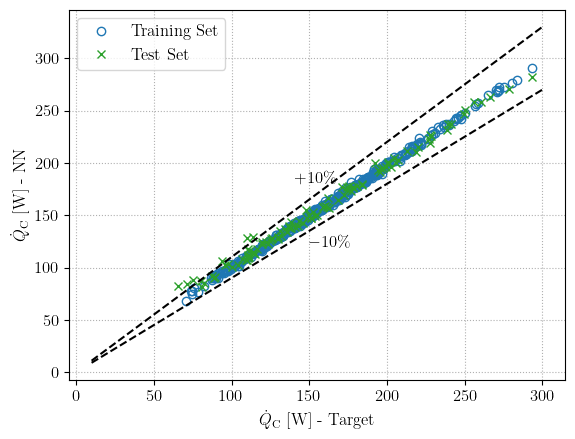

In [60]:
NeuNet(X_train,y_train,1000,'Qc')

Trial 725 Complete [00h 00m 34s]
val_loss: 0.14185462892055511

Best val_loss So Far: 0.14185462892055511
Total elapsed time: 01h 57m 55s
INFO:tensorflow:Oracle triggered exit
Epoch 1/500
14/14 [==============================] - 0s 2ms/step - loss: 2.7661 - mean_squared_error: 2.7661
Epoch 2/500
14/14 [==============================] - 0s 962us/step - loss: 3.5291 - mean_squared_error: 3.5291
Epoch 3/500
14/14 [==============================] - 0s 1ms/step - loss: 4.4306 - mean_squared_error: 4.4306
Epoch 4/500
14/14 [==============================] - 0s 773us/step - loss: 2.4673 - mean_squared_error: 2.4673
Epoch 5/500
14/14 [==============================] - 0s 1ms/step - loss: 3.6085 - mean_squared_error: 3.6085
Epoch 6/500
14/14 [==============================] - 0s 1ms/step - loss: 4.2519 - mean_squared_error: 4.2519
Epoch 7/500
14/14 [==============================] - 0s 921us/step - loss: 3.6125 - mean_squared_error: 3.6125
Epoch 8/500
14/14 [==============================] - 0s

Epoch 73/500
14/14 [==============================] - 0s 946us/step - loss: 2.2872 - mean_squared_error: 2.2872
Epoch 74/500
14/14 [==============================] - 0s 945us/step - loss: 2.6290 - mean_squared_error: 2.6290
Epoch 75/500
14/14 [==============================] - 0s 1ms/step - loss: 2.9502 - mean_squared_error: 2.9502
Epoch 76/500
14/14 [==============================] - 0s 888us/step - loss: 4.1253 - mean_squared_error: 4.1253
Epoch 77/500
14/14 [==============================] - 0s 1000us/step - loss: 2.8368 - mean_squared_error: 2.8368
Epoch 78/500
14/14 [==============================] - 0s 966us/step - loss: 5.0038 - mean_squared_error: 5.0038
Epoch 79/500
14/14 [==============================] - 0s 1ms/step - loss: 5.3547 - mean_squared_error: 5.3547
Epoch 80/500
14/14 [==============================] - 0s 802us/step - loss: 3.6282 - mean_squared_error: 3.6282
Epoch 81/500
14/14 [==============================] - 0s 959us/step - loss: 2.7984 - mean_squared_error: 2.

14/14 [==============================] - 0s 907us/step - loss: 4.0805 - mean_squared_error: 4.0805
Epoch 147/500
14/14 [==============================] - 0s 969us/step - loss: 3.4073 - mean_squared_error: 3.4073
Epoch 148/500
14/14 [==============================] - 0s 928us/step - loss: 4.2940 - mean_squared_error: 4.2940
Epoch 149/500
14/14 [==============================] - 0s 1ms/step - loss: 3.5672 - mean_squared_error: 3.5672
Epoch 150/500
14/14 [==============================] - 0s 1ms/step - loss: 5.1889 - mean_squared_error: 5.1889
Epoch 151/500
14/14 [==============================] - 0s 870us/step - loss: 2.8556 - mean_squared_error: 2.8556
Epoch 152/500
14/14 [==============================] - 0s 1ms/step - loss: 3.0914 - mean_squared_error: 3.0914
Epoch 153/500
14/14 [==============================] - 0s 783us/step - loss: 4.5655 - mean_squared_error: 4.5655
Epoch 154/500
14/14 [==============================] - 0s 967us/step - loss: 3.3224 - mean_squared_error: 3.3224
Epo

Epoch 219/500
14/14 [==============================] - 0s 973us/step - loss: 2.1359 - mean_squared_error: 2.1359
Epoch 220/500
14/14 [==============================] - 0s 869us/step - loss: 2.8640 - mean_squared_error: 2.8640
Epoch 221/500
14/14 [==============================] - 0s 944us/step - loss: 2.1095 - mean_squared_error: 2.1095
Epoch 222/500
14/14 [==============================] - 0s 899us/step - loss: 3.4899 - mean_squared_error: 3.4899
Epoch 223/500
14/14 [==============================] - 0s 956us/step - loss: 3.7355 - mean_squared_error: 3.7355
Epoch 224/500
14/14 [==============================] - 0s 950us/step - loss: 4.5509 - mean_squared_error: 4.5509
Epoch 225/500
14/14 [==============================] - 0s 935us/step - loss: 2.7378 - mean_squared_error: 2.7378
Epoch 226/500
14/14 [==============================] - 0s 907us/step - loss: 4.2886 - mean_squared_error: 4.2886
Epoch 227/500
14/14 [==============================] - 0s 938us/step - loss: 5.1766 - mean_squar

14/14 [==============================] - 0s 950us/step - loss: 3.7217 - mean_squared_error: 3.7217
Epoch 292/500
14/14 [==============================] - 0s 946us/step - loss: 2.9900 - mean_squared_error: 2.9900
Epoch 293/500
14/14 [==============================] - 0s 1ms/step - loss: 5.1144 - mean_squared_error: 5.1144
Epoch 294/500
14/14 [==============================] - 0s 1ms/step - loss: 4.1356 - mean_squared_error: 4.1356
Epoch 295/500
14/14 [==============================] - 0s 366us/step - loss: 2.5130 - mean_squared_error: 2.5130
Epoch 296/500
14/14 [==============================] - 0s 1ms/step - loss: 2.2262 - mean_squared_error: 2.2262
Epoch 297/500
14/14 [==============================] - 0s 958us/step - loss: 2.8124 - mean_squared_error: 2.8124
Epoch 298/500
14/14 [==============================] - 0s 820us/step - loss: 2.5355 - mean_squared_error: 2.5355
Epoch 299/500
14/14 [==============================] - 0s 926us/step - loss: 3.6464 - mean_squared_error: 3.6464
Epo

14/14 [==============================] - 0s 782us/step - loss: 2.6576 - mean_squared_error: 2.6576
Epoch 364/500
14/14 [==============================] - 0s 938us/step - loss: 6.6111 - mean_squared_error: 6.6111
Epoch 365/500
14/14 [==============================] - 0s 959us/step - loss: 2.9584 - mean_squared_error: 2.9584
Epoch 366/500
14/14 [==============================] - 0s 978us/step - loss: 5.4869 - mean_squared_error: 5.4869
Epoch 367/500
14/14 [==============================] - 0s 952us/step - loss: 6.1090 - mean_squared_error: 6.1090
Epoch 368/500
14/14 [==============================] - 0s 1ms/step - loss: 4.1511 - mean_squared_error: 4.1511
Epoch 369/500
14/14 [==============================] - 0s 803us/step - loss: 3.4422 - mean_squared_error: 3.4422
Epoch 370/500
14/14 [==============================] - 0s 1ms/step - loss: 2.7640 - mean_squared_error: 2.7640
Epoch 371/500
14/14 [==============================] - 0s 790us/step - loss: 2.1690 - mean_squared_error: 2.1690
E

14/14 [==============================] - 0s 889us/step - loss: 3.3504 - mean_squared_error: 3.3504
Epoch 436/500
14/14 [==============================] - 0s 1ms/step - loss: 2.8494 - mean_squared_error: 2.8494
Epoch 437/500
14/14 [==============================] - 0s 822us/step - loss: 3.9631 - mean_squared_error: 3.9631
Epoch 438/500
14/14 [==============================] - 0s 1ms/step - loss: 5.1518 - mean_squared_error: 5.1518
Epoch 439/500
14/14 [==============================] - 0s 952us/step - loss: 3.5129 - mean_squared_error: 3.5129
Epoch 440/500
14/14 [==============================] - 0s 962us/step - loss: 4.0879 - mean_squared_error: 4.0879
Epoch 441/500
14/14 [==============================] - 0s 1ms/step - loss: 3.5434 - mean_squared_error: 3.5434
Epoch 442/500
14/14 [==============================] - 0s 1ms/step - loss: 4.2177 - mean_squared_error: 4.2177
Epoch 443/500
14/14 [==============================] - 0s 799us/step - loss: 3.4928 - mean_squared_error: 3.4928
Epoch

The coefficient of determination for Wm Training Set using Neural Networks is 0.9970121810200865
The coefficient of determination for Wm Test Set using Neural Networks is 0.9978600288792827


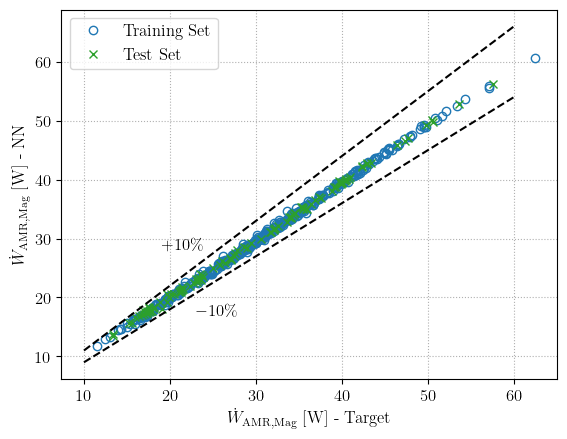

In [53]:
NeuNet(X_train,y_train,500,'Wm')